In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
import numpy as np
import random
from scipy.optimize import curve_fit
import scipy.stats as stats


import time
import os

save_graph = False

Creazione del grafo con l'algoritmo di Barabasi-Albert

In [2]:
N = 50
M = 2

G = nx.complete_graph(M)
G = nx.barabasi_albert_graph(N, M, initial_graph=G)

Rappresentazione del grafico

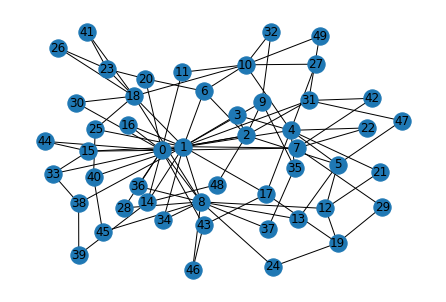

In [3]:
nx.draw(G, with_labels=True)    
plt.show()

if save_graph:
    nx.write_adjlist(G, "BA.adjlist")

Distribuzione della connettività dei nodi

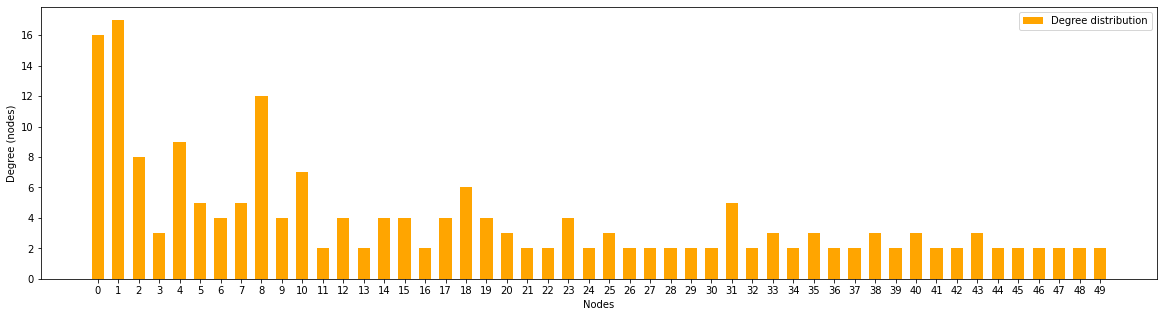

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.4*N, 5))

ax.bar(G.nodes, [d for n,d in G.degree], width=0.6, 
          align='center', color='orange', label='Degree distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Degree (nodes)")
ax.set_xticks(np.arange(0, N, 1))
# ax[i].grid(True)

plt.show()

Estrazione della matrice di adiacenza A

In [5]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)] 
    for c in b : 
        A[a][c] = 1

Estrazione della matrice di stocastica P e calcolo dei suoi autovalori e autovettori

In [6]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

In [7]:
matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)

diff = [np.abs(autovaloriP[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP[i] - 1) == minDiff:
        pS = autovettoriP[i]
        print("Eigenvector found")
        break

if pS[0] < 0:
    pS = -pS

Eigenvector found


In [8]:
autovaloriP

array([ 1.00000000e+00+0.00000000e+00j, -8.14202894e-01+0.00000000e+00j,
       -7.84715116e-01+0.00000000e+00j, -7.41907829e-01+0.00000000e+00j,
       -7.32230943e-01+0.00000000e+00j, -7.01603448e-01+0.00000000e+00j,
        7.66000969e-01+0.00000000e+00j,  7.31115487e-01+0.00000000e+00j,
        7.21126602e-01+0.00000000e+00j, -6.05729231e-01+0.00000000e+00j,
       -5.75444939e-01+0.00000000e+00j, -5.41329068e-01+0.00000000e+00j,
       -5.47526571e-01+0.00000000e+00j, -5.16508287e-01+0.00000000e+00j,
       -4.78425127e-01+0.00000000e+00j, -4.26267487e-01+0.00000000e+00j,
       -3.84756107e-01+0.00000000e+00j, -3.42364126e-01+0.00000000e+00j,
       -3.20177914e-01+0.00000000e+00j, -2.83115723e-01+0.00000000e+00j,
       -2.55648155e-01+0.00000000e+00j, -2.13591208e-01+0.00000000e+00j,
       -1.95759670e-01+0.00000000e+00j, -1.40345621e-01+0.00000000e+00j,
       -8.68638894e-02+0.00000000e+00j,  6.39616699e-01+0.00000000e+00j,
        6.11791305e-01+0.00000000e+00j,  5.71419801

Definizione della matrice laplaciana L e calcolo dei suoi autovettori e autovalori

In [9]:
matrixL = np.identity(N) - matrixP

In [10]:
autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)

diff = [np.abs(autovaloriL[i]) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriL[i]) == minDiff:
        pS_L = autovettoriL[i]
        FiedlerEigenvalues = list(autovaloriL)
        FiedlerEigenvalues.remove(autovaloriL[i])
        print("Eigenvector found")
        break

if pS_L[0] < 0:
    pS_L = -pS_L

Eigenvector found


In [11]:
np.sort(autovaloriL)

array([-1.11022302e-15,  2.33999031e-01,  2.68884513e-01,  2.78873398e-01,
        3.60383301e-01,  3.88208695e-01,  4.28580199e-01,  4.41269742e-01,
        4.88232738e-01,  5.01495176e-01,  5.37100676e-01,  5.53322613e-01,
        5.82180750e-01,  6.37842904e-01,  7.08383177e-01,  7.47386937e-01,
        7.55060849e-01,  7.88369329e-01,  8.23957528e-01,  8.62345822e-01,
        9.25609265e-01,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.08686389e+00,  1.14034562e+00,  1.19575967e+00,
        1.21359121e+00,  1.25564816e+00,  1.28311572e+00,  1.32017791e+00,
        1.34236413e+00,  1.38475611e+00,  1.42626749e+00,  1.47842513e+00,
        1.51650829e+00,  1.54132907e+00,  1.54752657e+00,  1.57544494e+00,
        1.60572923e+00,  1.70160345e+00,  1.73223094e+00,  1.74190783e+00,
        1.78471512e+00,  1.81420289e+00])

La distribuzione stazionaria e il valore di Fiedler estratto dalle due matrici L e P coincidono fino alla 13-esima cifra decimale

In [12]:
i = 13
np.round(pS, i) == np.round(pS_L, i)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [13]:
np.round(1-max(autovaloriP[1:]), i) == np.round(min(autovaloriL[1:]), i)

True

Definizione del valore valore di Fiedler e della distribuzione stazionaria approssimate

In [14]:
FiedlerValue = round(min(FiedlerEigenvalues).real, i)
print(FiedlerValue)

0.2339990309438


In [15]:
pS = np.round(pS.real, i)
print(pS)

[0.44547684 0.47331914 0.22273842 0.08352691 0.25058072 0.13921151
 0.11136921 0.13921151 0.33410763 0.11136921 0.19489612 0.0556846
 0.11136921 0.0556846  0.11136921 0.11136921 0.0556846  0.11136921
 0.16705381 0.11136921 0.08352691 0.0556846  0.0556846  0.11136921
 0.0556846  0.08352691 0.0556846  0.0556846  0.0556846  0.0556846
 0.0556846  0.13921151 0.0556846  0.08352691 0.0556846  0.08352691
 0.0556846  0.0556846  0.08352691 0.0556846  0.08352691 0.0556846
 0.0556846  0.08352691 0.0556846  0.0556846  0.0556846  0.0556846
 0.0556846  0.0556846 ]


In [16]:
if save_graph:
    np.savetxt("BA-pS.txt", pS, delimiter='\n')

Assegnazione degli individui ai nodi per l'evoluzione della dinamica. L'assegnazione degli individui può essere fatta secondo una distribuzione uniforme oppure concentrando tutti gli indivisui in un punto.

In [17]:
walker_per_node = 1000

start_node = N-3
walkers = int(5e4)

In [18]:
def dynamic_evolution(G, history = []):
    seed = np.random.RandomState()
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(int(G.nodes[n]['N_i'])):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[new_node] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[n]
    history += [evolution]

In [19]:
history = [[], [], []]
for h in range(len(history)):
#     history[h] = [[walker_per_node] * len(G.nodes)]
    history[h] = [[0] * len(G.nodes)]
    history[h][0][start_node] = walkers

In [20]:
time_steps = int(5e1)

In [21]:
t0 = time.time()

for h in range(len(history)):
    for n in G.nodes:
#         G.nodes[n]['N_i'] = walker_per_node
        G.nodes[n]['N_i'] = 0
    G.nodes[start_node]['N_i'] = walkers
    
    for t in range(time_steps):
        dynamic_evolution(G, history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 1 minutes and 17.78767728805542 seconds


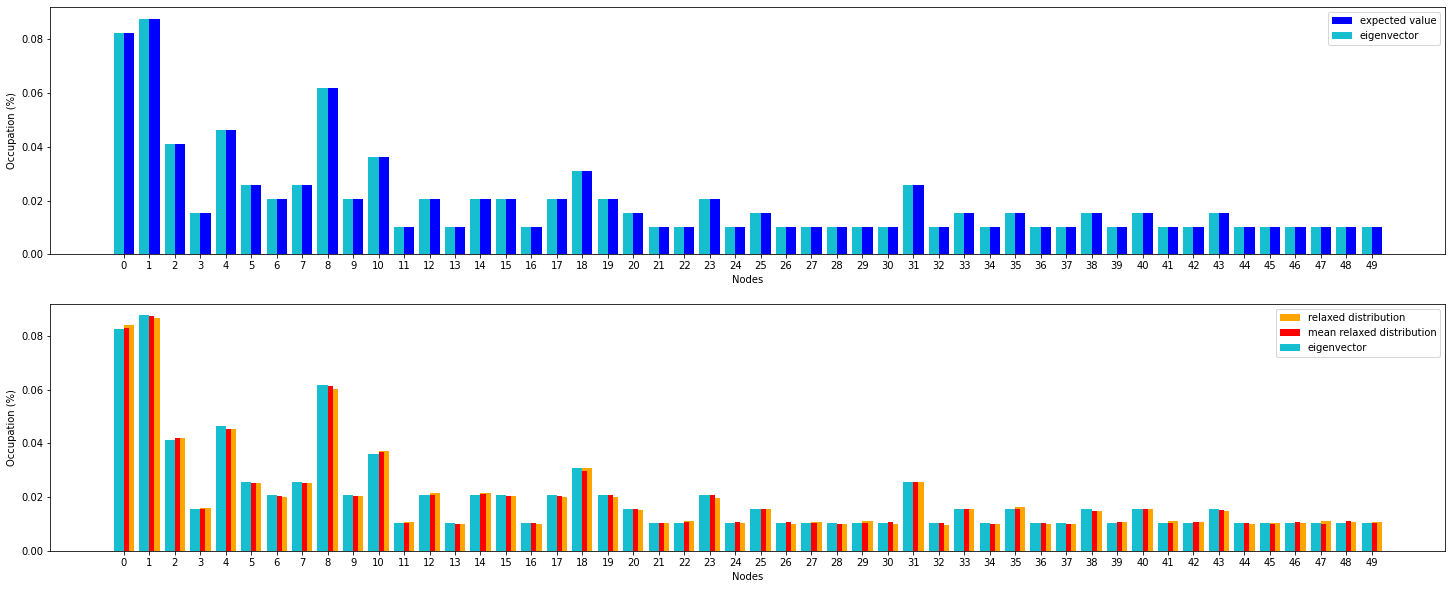

In [22]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSExpected = [d for n, d in G.degree()]
pSNorm = [h/sum(pS) for h in pS]

total_walkers = sum(history[0][0])

hMean = [[(h1+h2+h3)/total_walkers/3 
          for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

ax[0].bar(G.nodes, [h/sum(pSExpected) for h in pSExpected], width=0.4, align='edge', color='blue', label="expected value")
ax[0].bar(G.nodes, [h for h in pSNorm], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

ax[1].bar(G.nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax[1].bar(G.nodes, hMean[-1], width=0.2, align='edge', color='red', label='mean relaxed distribution')
ax[1].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)


plt.show()

In [23]:
print(pSNorm)

[0.08247422680412031, 0.08762886597936163, 0.041237113402060155, 0.0154639175257795, 0.04639175257731999, 0.025773195876280654, 0.02061855670102082, 0.025773195876280654, 0.061855670103080976, 0.02061855670102082, 0.03608247422680032, 0.010309278350519667, 0.02061855670102082, 0.010309278350519667, 0.02061855670102082, 0.02061855670102082, 0.010309278350519667, 0.02061855670102082, 0.030927835051540488, 0.02061855670102082, 0.0154639175257795, 0.010309278350519667, 0.010309278350519667, 0.02061855670102082, 0.010309278350519667, 0.0154639175257795, 0.010309278350519667, 0.010309278350519667, 0.010309278350519667, 0.010309278350519667, 0.010309278350519667, 0.025773195876280654, 0.010309278350519667, 0.0154639175257795, 0.010309278350519667, 0.0154639175257795, 0.010309278350519667, 0.010309278350519667, 0.0154639175257795, 0.010309278350519667, 0.0154639175257795, 0.010309278350519667, 0.010309278350519667, 0.0154639175257795, 0.010309278350519667, 0.010309278350519667, 0.0103092783505

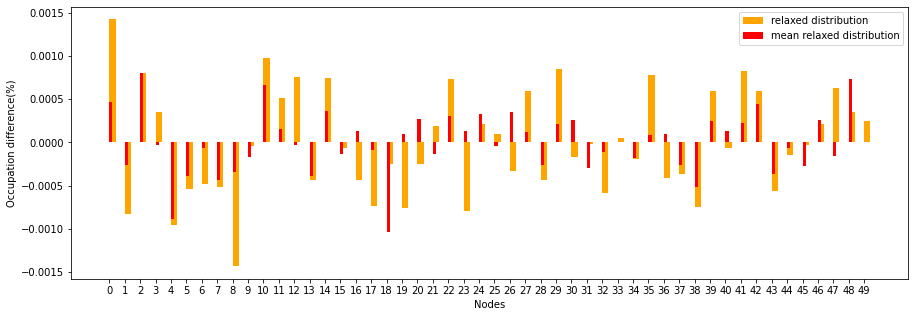

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.3*N, 5))

ax.bar(G.nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm)], width=0.4, 
       align='edge', color='orange', label='relaxed distribution')
ax.bar(G.nodes, [(h1+h2+h3)/(sum(history[0][-1]) + sum(history[1][-1]) + sum(history[2][-1])) - k 
                 for h1, h2, h3, k in zip(history[0][-1], history[1][-1], history[2][-1], pSNorm)],
       width=0.2, align='edge', color='red', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Occupation difference(%)")
ax.set_xticks(np.arange(0, N, 1))
# ax.grid(True)

plt.show()

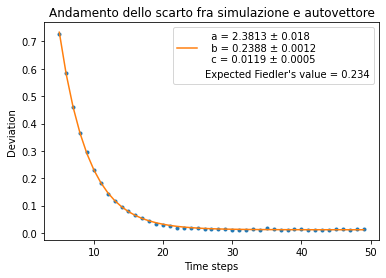

In [25]:
def exp_law(x, a, b, c):
    return a*np.exp(-b*x) +c

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(6,4))

time_evolution = [[h1 for h1 in hMean[i]] for i in range(len(history[0]))]
time = np.arange(5, 50)

y = [sum([np.abs(time_evolution[t][n] - pSNorm[n]) for n in G.nodes]) for t in time]

popt, pcov = curve_fit(exp_law, time, y, p0=[1, FiedlerValue, 0])
err = np.sqrt(np.diag(pcov))

ax.plot(time, y, '.')
ax.plot(time, exp_law(time, *popt), '-',
        label = f"  a = {round(popt[0],4)} ± {round(err[0], 4)}\n" + 
                f"  b = {round(popt[1],4)} ± {round(err[1], 4)}\n" +
                f"  c = {round(popt[2],4)} ± {round(err[2], 4)}")
ax.plot([30], [0.1], '-', 
        label = f"Expected Fiedler's value = {round(FiedlerValue, 4)}", 
        color = 'white')

ax.set_title(f"Andamento dello scarto fra simulazione e autovettore")
ax.set_xlabel("Time steps")
ax.set_ylabel("Deviation")

# plt.yscale('log')
ax.legend()

plt.show()

In [26]:
nodes = [8, 10, 25, N-1]

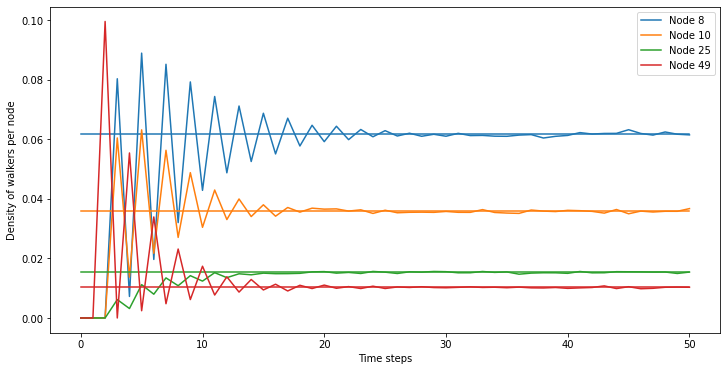

Evolution of 50 time steps for 50000 walkers


In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,1.5*len(nodes)))
# color = list(mcolors.CSS4_COLORS)
color = list(mcolors.TABLEAU_COLORS)

time_evolution = hMean
time = np.arange(0, len(time_evolution), 1)

col = 0
for i in nodes:
    ax.plot(time, [time_evolution[ind][i] for ind in time], label = f"Node {i}", color = color[col])
    ax.plot(time, [pSNorm[i]]*len(time),
#             label = f"Relaxed distribution of node {i}", 
            color = color[col])
    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()

print(f"Evolution of {time_steps} time steps for {total_walkers} walkers")

In [28]:
np.sort(autovaloriL)

array([-1.11022302e-15,  2.33999031e-01,  2.68884513e-01,  2.78873398e-01,
        3.60383301e-01,  3.88208695e-01,  4.28580199e-01,  4.41269742e-01,
        4.88232738e-01,  5.01495176e-01,  5.37100676e-01,  5.53322613e-01,
        5.82180750e-01,  6.37842904e-01,  7.08383177e-01,  7.47386937e-01,
        7.55060849e-01,  7.88369329e-01,  8.23957528e-01,  8.62345822e-01,
        9.25609265e-01,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.08686389e+00,  1.14034562e+00,  1.19575967e+00,
        1.21359121e+00,  1.25564816e+00,  1.28311572e+00,  1.32017791e+00,
        1.34236413e+00,  1.38475611e+00,  1.42626749e+00,  1.47842513e+00,
        1.51650829e+00,  1.54132907e+00,  1.54752657e+00,  1.57544494e+00,
        1.60572923e+00,  1.70160345e+00,  1.73223094e+00,  1.74190783e+00,
        1.78471512e+00,  1.81420289e+00])